# Creating a QA bot from technical documentation

This notebook demonstrates how to create a chatbot (single turn) that answers user questions based on technical documentation made available to the model.

We use the `aws-documentation` dataset ([link](https://github.com/siagholami/aws-documentation/tree/main)) for representativeness. This dataset contains 26k+ AWS documentation pages, preprocessed into 120k+ chunks, and 100 questions based on real user questions.

We proceed as follows:
1. Embed the AWS documentation into a vector database using Cohere's `embed` model and `llama_index`
2. Build a retriever using Cohere's `rerank` for better accuracy, lower inference costs and lower latency
3. Create model answers for the eval set of 100 questions using Cohere's `command-r` model
4. Evaluate the generated answers against the golden answers of the eval set using `command-r+`, Cohere's most capable generative model as a judge


## Setup

In [ ]:
%%capture
!pip install cohere datasets llama_index llama-index-llms-cohere llama-index-embeddings-cohere

In [1]:
import os
import cohere
import datasets
from llama_index.core import StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.core.schema import TextNode
from llama_index.embeddings.cohere import CohereEmbedding
import pandas as pd

import json
from pathlib import Path
from tqdm import tqdm
from typing import List

from dotenv import load_dotenv
load_dotenv()


/Users/neel/Library/Caches/pypoetry/virtualenvs/notebooks-WcB_wkWy-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [18]:
# Set up Cohere client
# TODO: delete before push
api_key = os.getenv("COHERE_API_KEY") # <your API key>
co = cohere.Client(api_key=api_key, log_warning_experimental_features=False)

stub_len = len("https://github.com/siagholami/aws-documentation/tree/main/documents/")

## 1. Embed technical documentation and store as vector database

* Load the dataset from HuggingFace
* Compute embeddings using Cohere's implementation in LlamaIndex, `CohereEmbedding`
* Store inside a vector database, `VectorStoreIndex` from LlamaIndex


Because this process is lengthy (~2h for all documents on a MacBookPro), we store the index to disc for future reuse. We also provide an option to to index only a subset of the data. This can be enabled by setting the value of the variable `USE_SNIPPET` to `True` in the block below. If you use this option, bear in mind that many documents will become unavailable to the model and, as a result, performance will suffer!

In [5]:
# Set to true if you want to use only a small sample of the training data (~5000) rows
USE_SNIPPET = True

data = datasets.load_dataset("sauravjoshi23/aws-documentation-chunked")
# The data comes prechunked. We keep the data as-is in this notebook.
# For more information on optimal preprocessing strategies, please check
# our other notebooks!

# Add a column with the shortened source. This will be used to cross-reference with the QA Evaluation dataset to ensure
# that the relevant testing data sources are captured in the smaller samples of data selected
if USE_SNIPPET:
    data = data.map(lambda x: {"short_source": x["source"][stub_len:].replace("/doc_source", "")})

# Build a mapping from sample id to index inside data (will be useful for retrieval later)
map_id2index = {sample["id"]: index for index, sample in enumerate(data["train"])}

print(data["train"])


Dataset({
    features: ['id', 'text', 'source', 'short_source'],
    num_rows: 187147
})


To assess the performance of our RAG pipeline, we will also need some QA pairs to validate the answers generated by `command`. The author of the repository above provides 100 QA pairs that we can test the model on. Let's download these questions.

**NOTE**: if you have set `USE_SNIPPET` to `True`, the following block also creates a separate copy of the dataset with documents that the QA pairs test on, so that we can ensure that these particular documents are always included as a subset in the smaller sampled training set.

In [6]:
# -- to fix SSL error -- 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Load data from github
url = "https://github.com/siagholami/aws-documentation/blob/main/QA_true.csv?raw=true"
qa_pairs = pd.read_csv(url)

# Filters and extracts the rows in the data that correspond with documents that are referenced
# in the QA pairs test set
if USE_SNIPPET:
    golden_docs = qa_pairs['Document_True'].tolist()
    golden_doc_data = data.filter(lambda x: x['short_source'] in golden_docs)

Filter: 100%|██████████| 187147/187147 [00:00<00:00, 404111.70 examples/s]


In [7]:
# Create index in vector database, and persist it for later reuse
# Note: this cell takes about ~2h on a MacBookPro

overwrite = True # only compute index if it doesn't exist
path_index = Path(".") / "aws-documentation_index_cohere"

# Select Cohere's new `embed-english-v3.0` as the engine to compute embeddings
embed_model = CohereEmbedding(
    cohere_api_key=api_key,
    model_name="embed-english-v3.0",
)
 
if not path_index.exists() or overwrite:
    # Documents are prechunked. Keep them as-is for now
    documents = [
        # -- for indexing full dataset --
        # TextNode(
        #     text=sample["text"],
        #     title=sample["source"][stub_len:], # save source minus stub
        #     id_=sample["id"],
        # ) for sample in data["train"]
        # -- for testing on subset --
        TextNode(
            text=data["train"][index]["text"],
            title=data["train"][index]["source"][stub_len:],
            id_=data["train"][index]["id"],
        ) for index in range(5_000)
    ]

    # extend the sample of documents with the documents referenced in the QA pairs
    # test set
    if USE_SNIPPET:
        documents.extend(
            [
                TextNode(
                    text=data["text"],
                    title=data["source"][stub_len:],
                    id_=data["id"],
                ) for data in golden_doc_data["train"]
            ]
        )

    index = VectorStoreIndex(documents, embed_model=embed_model)
    index.storage_context.persist(path_index)

else:
    storage_context = StorageContext.from_defaults(persist_dir=path_index)
    index = load_index_from_storage(storage_context, embed_model=embed_model)


## 2. Build a retriever using Cohere's `rerank`

The vector database we built using `VectorStoreIndex` comes with an in-built retriever. We can call that retriever to fetch the top $k$ documents most relevant to the user question with:

```python
retriever = index.as_retriever(similarity_top_k=top_k)
```

We recently released [Rerank-3](https://txt.cohere.com/rerank-3/) (April '24), which we can use to improve the quality of retrieval, as well as reduce latency and the cost of inference. To use the retriever with `rerank`, we create a thin wrapper around `index.as_retriever` as follows:

In [8]:
class RetrieverWithRerank:
    def __init__(self, retriever, api_key):
        self.retriever = retriever
        self.co = cohere.Client(api_key=api_key)

    def retrieve(self, query: str, top_n: int):
        # First call to the retriever fetches the closest indices
        nodes = self.retriever.retrieve(query)
        nodes = [
            {
                "text": node.node.text,
                "llamaindex_id": node.node.id_,
            }
            for node
            in nodes
        ]
        # Call co.rerank to improve the relevance of retrieved documents
        reranked = self.co.rerank(query=query, documents=nodes, model="rerank-english-v3.0", top_n=top_n)
        nodes = [nodes[node.index] for node in reranked.results]
        return nodes


top_k = 60 # how many documents to fetch on first pass
top_n = 20 # how many documents to sub-select with rerank

# Instantiate retriver
retriever = RetrieverWithRerank(
    index.as_retriever(similarity_top_k=top_k),
    api_key=api_key,
)


In [9]:
# Test the retriever on a single question!
query = "What happens to my Amazon EC2 instances if I delete my Auto Scaling group?"

# Retrieving relevant documents with rerank now fits in one line
documents = retriever.retrieve(query, top_n=top_n)

# Call Cohere's RAG pipeline with co.chat and the `documents` argument
resp = co.chat(message=query, model="command-r", temperature=0., documents=documents)
print(resp.text)


Deleting an Auto Scaling group will stop and terminate all of your Amazon EC2 instances within that group. 

However, you may want to instead stop or terminate your Amazon EC2 instances individually, especially if you no longer need them running. This can be done using alarm actions in CloudWatch.

If you want to remove an Auto Scaling group but keep your instances, you can follow the removal process described in the Amazon EC2 User Guide.


This works! With `co.chat`, you get the additional benefit that citations are returned for every span of text. Here's a simple function to display the citations inside square brackets.

In [10]:
def build_answer_with_citations(response):
    """ """
    text = response.text
    citations = response.citations

    # Construct text_with_citations adding citation spans as we iterate through citations
    end = 0
    text_with_citations = ""

    for citation in citations:
        # Add snippet between last citatiton and current citation
        start = citation.start
        text_with_citations += text[end : start]
        end = citation.end  # overwrite
        citation_blocks = " [" + ", ".join([stub[4:] for stub in citation.document_ids]) + "] "
        text_with_citations += text[start : end] + citation_blocks
    # Add any left-over
    text_with_citations += text[end:]

    return text_with_citations

grounded_answer = build_answer_with_citations(resp)
print(grounded_answer)


Deleting an Auto Scaling group will stop and terminate [14]  all of your Amazon EC2 instances [14]  within that group. [14]  

However, you may want to instead stop or terminate your Amazon EC2 instances individually [6] , especially if you no longer need them running. [6]  This can be done using alarm actions in CloudWatch. [6] 

If you want to remove an Auto Scaling group but keep your instances [18] , you can follow the removal process described in the Amazon EC2 User Guide. [18] 


## 3. Create model answers for 100 QA pairs

Now that we have a running pipeline, we need to assess its performance.

We can now run inference on all of the QA test pairs (100 questions). Later, we will use Command-R+ -- Cohere's largest and most powerful model -- to measure performance.

We'll use the fields as follows:
* `Question`: the user question, passed to `co.chat` to generate the answer
* `Answer_True`: treat as the ground gruth; compare to the model-generated answer to determine its correctness
* `Document_True`: treat as the (single) golden document; check the rank of this document inside the model's retrieved documents

We'll loop over each question and generate our model answer. We'll also complete two steps that will be useful for evaluating our model next:
1. We compute the rank of the golden document amid the retrieved documents -- this will inform how well our retrieval system performs
2. We prepare the grading prompts -- these will be sent to an LLM scorer to compute the goodness of responses

In [12]:
# Define the LLM eval prompt
# We request a score and a reason for assigning that score to 'trigger CoT' and
# improve the model response

LLM_EVAL_TEMPLATE = \
"""
## References
{references}

QUESTION: based on the above reference documents, answer the following question: {question}
ANSWER: {answer}
STUDENT RESPONSE: {completion}

Based on the question (QUESTION) and answer above (ANSWER), grade the student's reponse (STUDENT RESPONSE). A correct response will contain exactly \
the same information as in the answer, even if it is worded differently. If the student's reponse is correct, \
give it a score of 1. Otherwise, give it a score of 0. Let's think step by step. Return your answer as \
as a compilable JSON with the following structure:
{{
    "reasoning": <reasoning>,
    "score: <score of 0 or 1>,
}}
"""
# Response format to enforce the model to produce a JSONic structure with its response
# as instructed by the eval prompt above
RESPONSE_FORMAT = {
    "type": "json_object",
    "schema": {
        "type": "object",
        "required": ["reasoning", "score"],
        "properties": {
            "reasoning": { "type": "string" },
            "score": { "type": "integer"}
        }
    }
}

def get_rank_of_golden_within_retrieved(golden: str, retrieved: List[dict]) -> int:
    """
    Returns the rank that the golden document (single) has within the retrieved documents
    * `golden` contains the source of the document, e.g. 'amazon-ec2-user-guide/EBSEncryption.md'
    * `retrieved` has a list of responses with key 'llamaindex_id', which links back to document sources
    """
    # Create {document: rank} map using llamaindex_id (count first occurrence of any document; they can
    # appear multiple times because they're chunked)
    doc_to_rank = {}
    for rank, doc in enumerate(retrieved):
        # retrieve source of document
        _id = doc["llamaindex_id"]
        source = data["train"][map_id2index[_id]]["source"]
        # format as in dataset
        source = source[stub_len:]  # remove stub
        source = source.replace("/doc_source", "")  # remove /doc_source/
        
        if source not in doc_to_rank:
            doc_to_rank[source] = rank + 1

    # Return rank of `golden`, defaulting to len(retrieved) + 1 if it's absent
    return doc_to_rank.get(golden, len(retrieved) + 1)


In [13]:
from tqdm import tqdm

answers = []
golden_answers = []
ranks = []
grading_prompts = []  # best computed in batch

for _, row in tqdm(qa_pairs.iterrows(), total=len(qa_pairs)):
    query, golden_answer, golden_doc = row["Question"], row["Answer_True"], row["Document_True"]
    golden_answers.append(golden_answer)

    # --- Produce answer using retriever ---
    documents = retriever.retrieve(query, top_n=top_n)
    resp = co.chat(
        message=query,
        model="command-r",
        temperature=0,
        documents=documents,
    )
    answer = resp.text
    answers.append(answer)

    # --- Do some prework for evaluation later ---
    # Rank
    rank = get_rank_of_golden_within_retrieved(golden_doc, documents)
    ranks.append(rank)
    # Score: construct the grading prompts for LLM evals, then evaluate in batch
    # Need to reformat documents slightly
    documents = [{"index": str(i), "text": doc["text"]} for i, doc in enumerate(documents)]
    references_text = "\n\n".join("\n".join([f"{k}: {v}" for k, v in doc.items()]) for doc in documents)
    # ^ snippet looks complicated, but all it does it unpack all kwargs from `documents`
    # into text separated by \n\n
    grading_prompt = LLM_EVAL_TEMPLATE.format(
        references=references_text, question=query, answer=golden_answer, completion=answer
    )
    grading_prompts.append(grading_prompt)


100%|██████████| 100/100 [09:19<00:00,  5.59s/it]


In [14]:
import pickle

# Optional, to persist the grading_prompts list as a pickle object
with open("../data/grading_prompts.pkl", "wb") as f:
    pickle.dump(grading_prompts, f)

## 4. Evaluate model performance

We want to test our model performance on two dimensions:
1. How good is the final answer? We'll compare our model answer to the golden answer using Command-R+ as a judge.
2. How good is the retrieval? We'll use the rank of the golden document within the retrieved documents to this end.

Note that this pipeline is for illustration only. To measure performance in practice, we would want to run more in-depths tests on a broader, representative dataset.

In [15]:
# For simplicity, prepare a DataFrame with the results
results = pd.DataFrame()
results["answer"] = answers
results["golden_answer"] = qa_pairs["Answer_True"]
results["rank"] = ranks


### 4.1 Compare answer to golden answer

We'll use Command-R+ as a judge of whether the answers produced by our model convey the same information as the golden answers. Since we've defined the grading prompts earlier, we can simply ask our LLM judge to evaluate that grading prompt. After a little bit of postprocessing, we can then extract our model scores.

In [40]:
import pickle

scores = []
reasonings = []

def remove_backticks(text: str) -> str:
    """
    Some models are trained to output JSON in Markdown formatting:
    ```json {json object}```
    Remove the backticks from those model responses so that they become
    parasable by json.loads.
    """
    if text.startswith("```json"):
        text = text[7:]
    if text.endswith("```"):
        text = text[:-3]
    return text


# -- uncomment to load saved grading_prompts list --
with open("../data/grading_prompts.pkl", "rb") as f:
    grading_prompts = pickle.load(f)

for prompt in tqdm(grading_prompts, total=len(grading_prompts)):
    resp = co.chat(
       message=prompt, 
       model="command-r-plus", 
       temperature=0., 
       response_format=RESPONSE_FORMAT,
    )
    # Convert response to JSON to extract the `score` and `reasoning` fields
    # We remove backticks for compatibility with different LLMs
    parsed = json.loads(resp.text)
    scores.append(parsed["score"])
    reasonings.append(parsed["reasoning"])


100%|██████████| 100/100 [06:41<00:00,  4.02s/it]


In [20]:
import pickle

# Optional, to persist scores and reasonings lists
with open("../data/scores.pkl", "wb") as f:
    pickle.dump(scores, f)
with open("../data/reasonings.pkl", "wb") as f:
    pickle.dump(reasonings, f)

In [21]:
import pickle

# -- uncomment to load saved scores, reasonings lists --
with open("../data/scores.pkl", "rb") as f:
   scores = pickle.load(f)
with open("../data/reasonings.pkl", "rb") as f:
   reasonings = pickle.load(f)

# Add scores to our DataFrame
results["score"] = scores
results["reasoning"] = reasonings

In [22]:
print(f"Average score: {results['score'].mean():.3f}")


Average score: 0.980


### 4.2 Compute rank

We've already computed the rank of the golden documents using `get_rank_of_golden_within_retrieved`. Here, we'll plot the histogram of ranks, using blue when the answer scored a 1

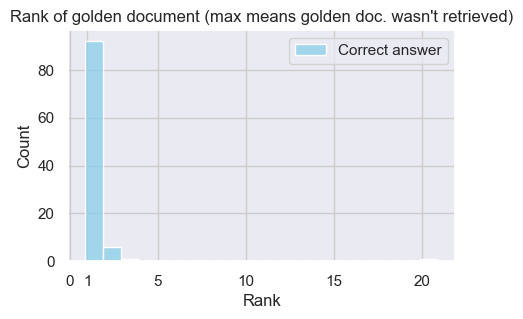

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", rc={"grid.color": ".8"})

# create offsets for better vis
results["rank_shifted_left"] = results["rank"] - 0.1
results["rank_shifted_right"] = results["rank"] + 0.1

f, ax = plt.subplots(figsize=(5, 3))
sns.histplot(data=results, x="rank_shifted_left", color="skyblue", label="Correct answer", binwidth=1)

ax.set_xticks([1, 5, 0, 10, 15, 20])
ax.set_title("Rank of golden document (max means golden doc. wasn't retrieved)")
ax.set_xlabel("Rank")
ax.legend();


We see that retrieval works well overall: for 80% of questions, the golden document is within the top 5 documents. However, we also notice that approx. half the false answers come from instances where the golden document wasn't retrieved (`rank = top_k = 20`). This should be improved, e.g. by adding metadata to the documents such as their section headings, or altering the chunking strategy.

There is also a non-negligible instance of false answers where the top document was retrieved. On closer inspection, many of these are due to the model phrasing its answers more verbosely than the (very laconic) golden documents. This highlights the importance of checking eval results before jumping to conclusions about model performance.

## Conclusions

In this notebook, we've built a QA bot that answers user questions based on technical documentation. We've learnt:

1. How to embed the technical documentation into a vector database using Cohere embeddings and `llama_index`
2. How to build a custom retriever that leverages Cohere's `rerank`
3. How to evaluate model performance against a predetermined set of golden QA pairs

